# VAR & VAECM

[Reference](https://web.vu.lt/mif/a.buteikis/wp-content/uploads/2020/05/TasksP_06.html)

### Granger Causality
- We say that X Granger causes Y , if the past values of X have explanatory power for current values of Y

- To test this, We will generate X and Y in the following way:
$$
\begin{equation}
\left\{
    \begin{aligned}
        &X_{t}=0.2X_{t-1}+w_{t}, w_{t} ~ N(0,1) \\
        &Y_{t}=0.3Y_{t-1}-0.5Y_{t-2}+02.Y_{t-3} - 0.2X_{t-1}-0.3X{t-2}- 0.1X_{t-3} +\epsilon_{t}, \epsilon_{t}, N(1,0)
    \end{aligned}
\right.
\end{equation}
$$


In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.stats as sm_stat
import statsmodels.tsa as smt
import statsmodels.formula.api as smf

import scipy

import matplotlib.pyplot as plt


In [4]:
# We will simulate for a sample size of 500:

np.random.seed(1)

N= 500

X = np.zeros(N)
Y = np.zeros(N)

w = np.random.normal(loc=0.0, scale=1.0, size=N)
e = np.random.normal(loc=0.0, scale=1.0, size=N)

In [5]:
X[0] = w[0]
for j in range(1,N):
    X[j] = 0.2 * X[j -1] + w[j]

In [6]:
Y[0] = e[0]
Y[1] = 0.3*Y[0] -0.2*X[0] + e[1]
Y[2] = 0.3*Y[1] - 0.5*Y[0] - 0.2*X[1] - 0.3*X[0] + e[2]
for j in range(3,N):
    Y[j] = 0.3*Y[j-1] - 0.5*Y[j-2] + 0.2*Y[j-3] - 0.2*X[j-1] - 0.1*X[j-3] + e[j]

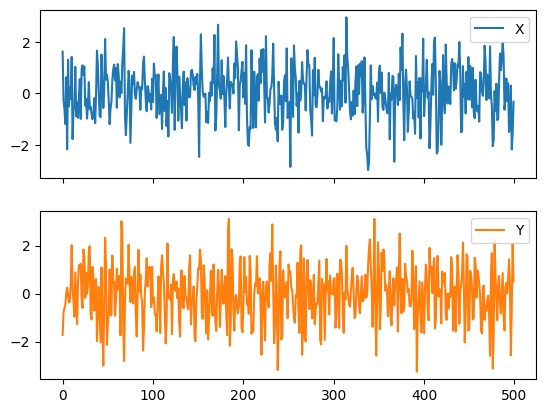

In [7]:
DT = pd.DataFrame([X,Y], index=["X","Y"]).T 
DT.plot(subplots=True, layout=(2,1))
plt.show()

### The Unrestricted model
We will begin by estimating an unrestricted model

$$
Y_{t}=\alpha+\delta t + \Phi_{1}Y_{t-1}+\cdots+\Phi_{p}Y_{t-p} + \beta_{1}X_{t-1}+\cdots+\beta{q}X_{t-q}+\epsilon_{t}
$$

We have already learned of the sequential procedure to choose p and q in the model. On the other hand, in the Granger causality case, this is not the question of the first importance and so, we will assume p=q

In [9]:
#Lag operator:
def L(x, n=1):
    if n ==0:
        return x 
    if isinstance(x, pd.Series):
        return x.shift(n)
    else:
        x = pd.Series(x)
        return x.shift(n)
    
#Difference operator:
def d(x):
    if isinstance(x, pd.Series):
        return x.diff()
    else:
        x = pd.Series(x)
        return x.diff()
    
#Trend/time operator:
def time(x):
    return list(range(1, len(x)+1))

In [10]:
#We will also define a function to extract the coefficient table:

# Retrun the model coefficients of a 'smf.ols(...).fit()' object:
def get_coef(mdl_fit):
    result = np.round(pd.DataFrame([mdl_fit.params, mdl_fit.tvalues, mdl_fit.pvalues], index = ["coef","t-value","p-value"]).T, 5)
    return result

In [14]:
# We will begin by setting p=q=4:
mod_UR = smf.ols(formula='Y ~ 1 + time(Y) + L(Y,1) + L(Y,2) + L(Y,3) + L(Y,4) + L(X,1) + L(X,2) + L(X,3) + L(X,4)', data=DT).fit()
get_coef(mod_UR)

,coef,t-value,p-value
Intercept,0.04787,0.54096,0.58878
time(Y),-0.00010,-0.32228,0.74738
"L(Y, 1)",0.26202,5.83793,0.00000
"L(Y, 2)",-0.46455,-10.22176,0.00000
"L(Y, 3)",0.16020,3.49364,0.00052
"L(Y, 4)",0.05014,1.13970,0.25497
"L(X, 1)",-0.15223,-3.44886,0.00061
"L(X, 2)",-0.05110,-1.12546,0.26095
"L(X, 3)",-0.14430,-3.16914,0.00163
"L(X, 4)",0.13883,3.06702,0.00228


We then remove L(Y,4) and check for insignificant coefficients.

The, we remove time(Y) (because it is insignificant)

While we know that there is no intercept in our data generating pricess (i,e. DGP), it is worth also checking the mean of the series:

In [15]:
print("Series means are:\n", DT.mean(axis=0))
print("Series variances are:\n", DT.var(axis=0))

Series means are:
 X    0.066959
Y    0.003678
dtype: float64
Series variances are:
 X    1.011222
Y    1.299805
dtype: float64


So, it appears that the series has a zero-mean. We an verify this via a t-test where the null hypothesis are $H_{0} : \mathbb{E}(Y_{t})=0 \quad and \quad H_{0} : \mathbb{E}(E_{t})=0 $

In [16]:
print(scipy.stats.ttest_1samp(DT["X"], popmean = 0))
print(scipy.stats.ttest_1samp(DT["Y"], popmean = 0))

TtestResult(statistic=1.488923579649989, pvalue=0.13713920371635088, df=499)
TtestResult(statistic=0.07214391523471515, pvalue=0.9425162843573934, df=499)


So we do not reject the null hypothesis in either case the p-value > 0.05 for both series. Because of this, and the fact that Intercpet coeifficient is also insignificant after removing the previous two coefficients - we remove the Intercept as well

In [17]:
mod_UR = smf.ols(formula = 'Y ~ -1 + L(Y, 1) + L(Y, 2) + L(Y, 3) + L(X, 1) + L(X, 2) + L(X, 3) + L(X, 4)', data = DT).fit()
get_coef(mod_UR)

,coef,t-value,p-value
"L(Y, 1)",0.27075,6.11527,0.00000
"L(Y, 2)",-0.48852,-12.18635,0.00000
"L(Y, 3)",0.17474,3.95879,0.00009
"L(X, 1)",-0.14904,-3.38871,0.00076
"L(X, 2)",-0.04695,-1.03830,0.29964
"L(X, 3)",-0.14571,-3.21290,0.00140
"L(X, 4)",0.14073,3.12151,0.00191


### The Restricted Model
Because we want to test, if $X_{t-j},j>0$ improve the model of $Y_{t}$, we need to estimate a restricted model, where the restriction is that $\beta_{1}=\cdots=\beta_{q}=0$ 

$Y_{t}=\alpha +\delta t + \Phi_{1}Y_{t-1}+ \cdots + \Phi_{p}Y_{t-p}+\epsilon_{t}$

i.e. the coefficients of X Series are insignificnat.

In [18]:
mod_R = smf.ols(formula = 'Y ~ -1 + L(Y, 1) + L(Y, 2) + L(Y, 3)', data = DT).fit()
get_coef(mod_R)

,coef,t-value,p-value
"L(Y, 1)",0.27366,6.16296,0.00000
"L(Y, 2)",-0.48575,-11.89696,0.00000
"L(Y, 3)",0.15208,3.41972,0.00068


Note that we are not attempting to remove or add any coefficients to the Restricted model, as we are already imposing a restriction on $\beta_{j}$ coefficients, and we want to compare the UR and R models to see if those specific restrictions are valide

### Model Comparisony
To campare these two models, we will compare them by their SSR(sum of squared residuals, also known as residual sum of squares(RSS), or sum of squared errors of prediction (SSE)). We can do this by carrying out an ANOVA test

In [19]:
sm_stat.api.anova_lm(mod_R, mod_UR)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,490.661251,0.0,NaN,NaN,NaN
1,489.0,457.832432,5.0,32.828819,7.012737,0.000002


Since p-value < 0.05, we reject the null hypothesis $H_{0}: SSR_{R} = SSR_{UR}$. This means that the models are not identical. To check, which model is better, we can look at the SSR and the AIC, or BIC values.

In [20]:
pd.DataFrame([mod_R.ssr, mod_UR.ssr], index = ["Restricted", "Unrestricted"], columns = ["SSR"]).T

,Restricted,Unrestricted
SSR,490.661251,457.832432


In [21]:
pd.DataFrame([mod_R.aic, mod_UR.aic], index = ["Restricted", "Unrestricted"], columns = ["AIC"]).T

,Restricted,Unrestricted
AIC,1410.045384,1381.870977


In [22]:
pd.DataFrame([mod_R.bic, mod_UR.bic], index = ["Restricted", "Unrestricted"], columns = ["BIC"]).T

,Restricted,Unrestricted
BIC,1422.671154,1411.317008


We see that in all cases the  UR
  model is better: it has a lower SSR (i.e. the model errors are smaller) and a lower  AIC
  and  BIC
  value compares to the restricted model.

So, we can conclute that  X
  Granger causes  Y
 .

Now we are interested if this is the case the other way around. Remembering that we set  p=q
 , we are left with the following  UR
  model for  X
 :

In [23]:
X_UR = smf.ols(formula = 'X ~ -1 + L(Y, 1) + L(X, 1)', data = DT).fit()
get_coef(X_UR)

,coef,t-value,p-value
"L(Y, 1)",0.02506,0.64474,0.51939
"L(X, 1)",0.18368,4.17828,0.00003


In [24]:
# The restricted model:
X_R = smf.ols(formula = 'X ~ -1 + L(X, 1)', data = DT).fit()
get_coef(X_R)

,coef,t-value,p-value
"L(X, 1)",0.18357,4.1781,0.00003


In [25]:
# Now, we carry out the ANOVA test:
sm_stat.api.anova_lm(X_R, X_UR)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,498.0,487.127860,0.0,NaN,NaN,NaN
1,497.0,486.720764,1.0,0.407095,0.415693,0.519391


Since p-value > 0.05, we do not reject the null hypothesis  H0:SSRR=SSRUR
 .

This means that the errors of the two models are simialr in magnitude. In other words, including the additional coefficients from the lags of  Y
  series does not improve our model for  X
 , as our  SSR
  is not significantly different from the model  SSR
  without the lags of  Y
 .

Note that the errors themselves are not identical, i.e.  et,UR≠et,R
 , the results say that overall their squared residual sums are not statistically significantly different.

In [26]:
pd.DataFrame([X_R.ssr, X_UR.ssr], index = ["Restricted", "Unrestricted"], columns = ["SSR"]).T

,Restricted,Unrestricted
SSR,487.12786,486.720764


In [27]:
pd.DataFrame([X_R.aic, X_UR.aic], index = ["Restricted", "Unrestricted"], columns = ["AIC"]).T

,Restricted,Unrestricted
AIC,1406.085005,1407.667813


In [28]:
pd.DataFrame([X_R.bic, X_UR.bic], index = ["Restricted", "Unrestricted"], columns = ["BIC"]).T

,Restricted,Unrestricted
BIC,1410.297611,1416.093026


The  SSR
 ,  AIC
  and  BIC
  values are quite similar in both the  UR
  and  R
  cases.

We can conclude that  Y
  does not Granger cause  X
 .

### VAR: Estimation and Forecasting

For the sake of this example, assume that our VAR model is of the form:
$$
\begin{equation}
    \begin{pmatrix}
        Y_{t} \\
        X_{t}
    \end{pmatrix}
    =
    \begin{pmatrix}
        3 \\
        0
    \end{pmatrix}
    +
    \begin{pmatrix}
        0.5 &0.4 \\
        -0.2 &0.6
    \end{pmatrix}
    \begin{pmatrix}
        Y_{t-1}\\
        X_{t-1}
    \end{pmatrix}
    +
    \begin{pmatrix}
        -0.2 &-0.1 \\
        0.3 &0.1
    \end{pmatrix}
    \begin{pmatrix}
        Y_{t-2} \\
        X_{t-2}
    \end{pmatrix}
    +
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    ,
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    \sim
    \mathbb{N}
    \begin{pmatrix}
        \begin{bmatrix}
            0\\
            0
        \end{bmatrix}
        ,
        \begin{bmatrix}
            8 &6\\
            6 &9
        \end{bmatrix}
    \end{pmatrix}
\end{equation}
$$
i.e. we are analysing a VAR(2) model with correlated residuals


##### Specifying the parameters

In [3]:
nsample = 500

alpha = np.array([3,0])
theta_1 = np.array([[0.5, 0.4],[-0.2,0.6]])
theta_2 = np.array([[-0.2, -0.1], [0.3,0.1]])

mu = [0,0]
sigma = np.array([[8,6],[6,9]])

#### Generating the residuals¶
Note that the covariance matrix is always both symmetric and positive semi-definite. Equivalently, its eigenvalues are non-negative. We can verify this:

In [4]:
print("The eigenvalues: ", np.linalg.eigvals(sigma))
print("Are they non-negative? :", np.all(np.linalg.eigvals(sigma) >= 0))

The eigenvalues:  [ 2.47920271 14.52079729]
Are they non-negative? : True


We begin by generating our shocks, $\vec{\epsilon_{t}}$:

In [5]:
np.random.seed(1)
e = np.random.multivariate_normal(mu, sigma, size = nsample)

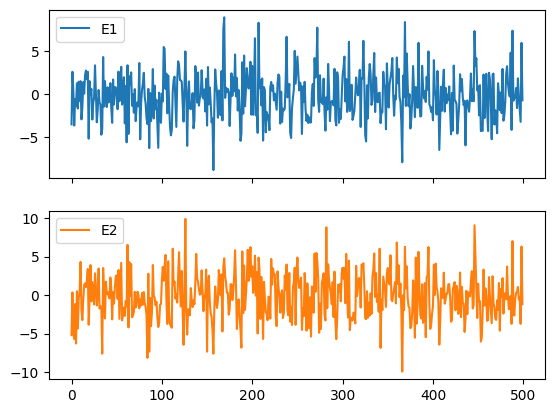

In [6]:
#Transform to DataFrame for easier plotin and stat calculation:
e_test = pd.DataFrame(e, columns = ["E1", "E2"])
e_test.plot(subplots=True, layout = (2, 1))
plt.show()

In [10]:
# The sample covariance:
e_test.cov()

,E1,E2
E1,7.273977,5.685325
E2,5.685325,9.022872


In [8]:
# The sample mean:
e_test.mean()

E1   -0.156420
E2   -0.098235
dtype: float64

#### Generating the data
Now, we can generate the data:

In [12]:
Y = np.zeros(shape=(nsample,2))
# The first 5 rows:
Y[:5, :]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

When t = 1, we have:

In [13]:
Y[0] = alpha + e[0]

When t =2:

In [14]:
Y[1] = alpha + np.dot(theta_1, Y[0]) + e[1]

When t > 2:

In [15]:
for j in range(2, nsample):
    Y[j] = alpha + np.dot(theta_1, Y[j-1]) + np.dot(theta_2, Y[j-2]) + e[j]

The resulting series:

In [16]:
Y[:5, :]

array([[ -0.48231193,  -5.20715159],
       [  3.28200428,  -2.69068434],
       [  4.6157294 ,  -7.81673238],
       [ -1.82613492, -10.60194712],
       [ -2.82956403,  -6.55339816]])

Most of time series models in Pylthon require that the pandas DataFrame object to have a valid date/time index, so we need to assign a date and frequency to the data - let's say that our data is daily, starting from 2014:

In [18]:
Y = pd.DataFrame(Y, columns=["Y","X"])
Y.index = pd.date_range(start="2014-01-01", periods = len(Y.index), freq="D").to_period()
Y.index = Y.index.to_timestamp()
Y.head()

,Y,X
2014-01-01,-0.482312,-5.207152
2014-01-02,3.282004,-2.690684
2014-01-03,4.615729,-7.816732
2014-01-04,-1.826135,-10.601947
2014-01-05,-2.829564,-6.553398


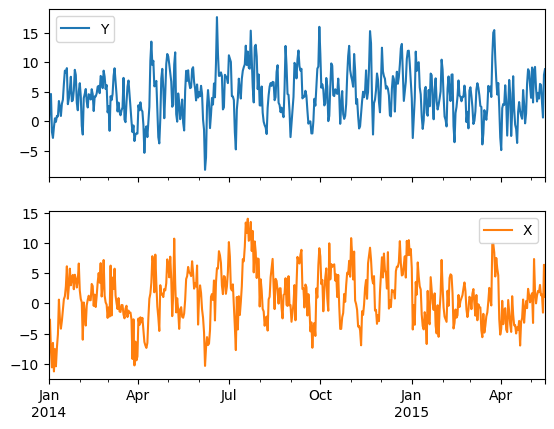

In [19]:
Y.plot(subplots=True, layout=(2,1))
plt.show()

#### Checking if a specific VAR model has a unit root

we also want to see, if the series is TS or DS. To do this, we can check if:
$$
    det(\mathcal{I}-\Theta_{1}z-\Theta_{2}z^{2})=0 \Longleftrightarrow |z_{j}| > 1, \forall\mathbb{j}
$$
i.e. if all the roots are outside the unit complex circle, then the process is stationary.
Fortunately, we can very easily do this in Python using symbolic expressions:

In [20]:
from sympy import *

In [21]:
z = Symbol('z')
D = Matrix([[1,0],[0,1]]) - Matrix(theta_1) * z - Matrix(theta_2) * (z**2)

In [23]:
D

Matrix([
[0.2*z**2 - 0.5*z + 1,      0.1*z**2 - 0.4*z],
[   -0.3*z**2 + 0.2*z, -0.1*z**2 - 0.6*z + 1]])

Next, we calculate the determinant:

In [24]:
D.det()

0.01*z**4 - 0.21*z**3 + 0.48*z**2 - 1.1*z + 1

We can also multiply the expressions in parenthesis by converting the result into a into a polynomial object:

In [25]:
temp_poly = Poly(D.det(),z)
temp_poly

Poly(0.01*z**4 - 0.21*z**3 + 0.48*z**2 - 1.1*z + 1.0, z, domain='RR')

In [26]:
temp_roots = roots(D.det(), z)
temp_roots

{1.23662943597335: 1,
 18.7362676595998: 1,
 0.513551452213425 - 2.01301370614087*I: 1,
 0.513551452213425 + 2.01301370614087*I: 1}

The real solution is:

z1 =  1.23662943597335

z2 = 18.7362676595998

The complex solution is:

z3 = 0.513551452213425 + 2.01301370614087⋅i

z4 = 0.513551452213425 − 2.01301370614087⋅i

The additional values are their multiplicities. Also, more root calculation examples using python.

To calculate the absolute values, we need to extract the roots:

In [27]:
temp_roots = [*temp_roots]
temp_roots

[1.23662943597335,
 18.7362676595998,
 0.513551452213425 - 2.01301370614087*I,
 0.513551452213425 + 2.01301370614087*I]

And use the Abs() function from sympy. We also use N(expr, 4) function to round the sympy results (which are a sympy object and not an ordinary value) to 4 decimal precision:

In [28]:
for j in temp_roots:
    print("z = ", N(j, 4), "=> |z| = ", N(Abs(j), 4))

z =  1.237 => |z| =  1.237
z =  18.74 => |z| =  18.74
z =  0.5135 - 2.013*I => |z| =  2.077
z =  0.5135 + 2.013*I => |z| =  2.077


So, all the roots are outside the unit circle, which means that this VAR model is stationary.

Note that in general we do not know the underlying DGP, so we would need to perform the ADF
or KPSS tests on each variable to verify whether they have a unit root or not.

### Estimating a VAR model

A VAR model can be stimated using the documented functions. It is worth reading the documentation as it not only provides examples on using the provided functions, but sometimes gives additional guidelines. For example:

The VAR class assumes that the passed time series are stationary.

Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method.

For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.

In [29]:
Y_VAR = smt.api.VAR(Y)

### Lag order selection

Choosing the lag order can be a difficult problem. Fortunately, we can use the automated procedure, which is based on calculating the information criteria for different lag orders:

Note: in case of errors like this one:

2-th leading minor of the array is not positive definite

make sure that the lag order is not too large (or the data sample too small). Also, this can happen if some roots |zj|
are very close to 1 (but still greater than 1).

In [32]:
order_result = Y_VAR.select_order(10)
print(order_result.ics)
print(order_result.selected_orders)

defaultdict(<class 'list'>, {'aic': [4.8903851955669895, 4.013641992274362, 3.516136291035466, 3.525482653433863, 3.536587896361216, 3.5388059518198647, 3.550327778464077, 3.5637865246849265, 3.5746800372432257, 3.5840101837145326, 3.594027092860149], 'bic': [4.907505217571498, 4.065002058287888, 3.60173640105801, 3.645322807465425, 3.6906680944017958, 3.727126193869462, 3.772888064522692, 3.8205868547525594, 3.8657204113198764, 3.909290601800201, 3.9535475549548353], 'hqic': [4.89710884069686, 4.0338129276639725, 3.5497545166848172, 3.5725481693429546, 3.597100702530048, 3.612766048248437, 3.63773516515239, 3.66464120163298, 3.6889820044510198, 3.711759441182067, 3.7352236405874244], 'fpe': [133.0047985507907, 55.348098158052416, 33.65419479035366, 33.970297544758154, 34.349798751814966, 34.42630804354283, 34.82559788913951, 35.29794671644388, 35.68519001651539, 36.020491612189, 36.3841108759811]})
{'aic': 2, 'bic': 2, 'hqic': 2, 'fpe': 2}


We see that the recommended model is VAR(2)
according to AIC, BIC, HQIC and FPE information criteria.

### Fitting the model

We will estimate a VAR(2) model:

In [33]:
results = Y_VAR.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     02:05:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.61278
Nobs:                     498.000    HQIC:                   3.56141
Log likelihood:          -2281.79    FPE:                    34.0636
AIC:                      3.52823    Det(Omega_mle):         33.3897
--------------------------------------------------------------------
Results for equation Y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.694126         0.241271           11.166           0.000
L1.Y          0.589969         0.050790           11.616           0.000
L1.X          0.370707         0.046172            8.029           0.000
L2.Y         -0.255685 

We can also examine the error covariance matrix:

In [34]:
results.resid.cov()

,Y,X
Y,7.208196,5.598939
X,5.598939,8.906885


In [35]:
results.resid.mean()

Y   -4.212605e-15
X   -2.454083e-15
dtype: float64

The estimated model is:
$$
\begin{equation}
\left\{
    \begin{aligned}
        &\hat Y_{t}=\ 2.694126 + 0.589969\hat Y_{t-1} + 0.370707 \hat X_{t-1} - 0.255685 \hat Y_{t-2} - 0.075897 \hat X_{t-2} \\
        &\hat X_{t}=\ -0.358460 - 0.074297 \hat Y_{t-1} + 0.565941 \hat X_{t-1} + 0.242305 \hat Y_{t-2} + 0.099620 \hat X_{t-2}
    \end{aligned}
\right.
\end{equation}
$$
The model residual covariance matrix is:
$$
\hat \sum_{\epsilon}\ =\ 
    \begin{bmatrix}
        7.208196 &5.598939 \\
        5.598939 &8.906885
    \end{bmatrix}
$$
Compared to the true model:
$$
\begin{equation}
    \begin{pmatrix}
        Y_{t} \\
        X_{t}
    \end{pmatrix}
    =
    \begin{pmatrix}
        3 \\
        0
    \end{pmatrix}
    +
    \begin{pmatrix}
        0.5 &0.4 \\
        -0.2 &0.6
    \end{pmatrix}
    \begin{pmatrix}
        Y_{t-1}\\
        X_{t-1}
    \end{pmatrix}
    +
    \begin{pmatrix}
        -0.2 &-0.1 \\
        0.3 &0.1
    \end{pmatrix}
    \begin{pmatrix}
        Y_{t-2} \\
        X_{t-2}
    \end{pmatrix}
    +
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    ,
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    \sim
    \mathbb{N}
    \begin{pmatrix}
        \begin{bmatrix}
            0\\
            0
        \end{bmatrix}
        ,
        \begin{bmatrix}
            8 &6\\
            6 &9
        \end{bmatrix}
    \end{pmatrix}
\end{equation}
$$

We see that, for the most part, the estimated parameters are close to the true parameter values. The same can be said for the error covariance matrix.

### Impulse-response functions

From the estimated VAR model, we can plot the impulse response functions of the endogenous variables.

Impulse responses are of interest in econometirc studies: they are the estimated responses to a unit impulse in one of the variables. They are computed in practice using the $\mathcal{MA}(\infty)$ representation of the VAR(p) process:
$$
    \vec Y_{t} =\ \vec \mu +\ \sum_{i=0}^{\infty} \Phi_{i}\vec \epsilon_{t-1}, \vec \epsilon_{t} \sim \mathbb{N}(\vec 0, \hat \sum_{\epsilon})
$$
Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix $\hat \sum_{\epsilon}$ and hence interpretations may change depending on variable ordering.

In [36]:
irf = results.irf(15)

We can compare the standard deviation shock to the non-orthogonalized residuals:

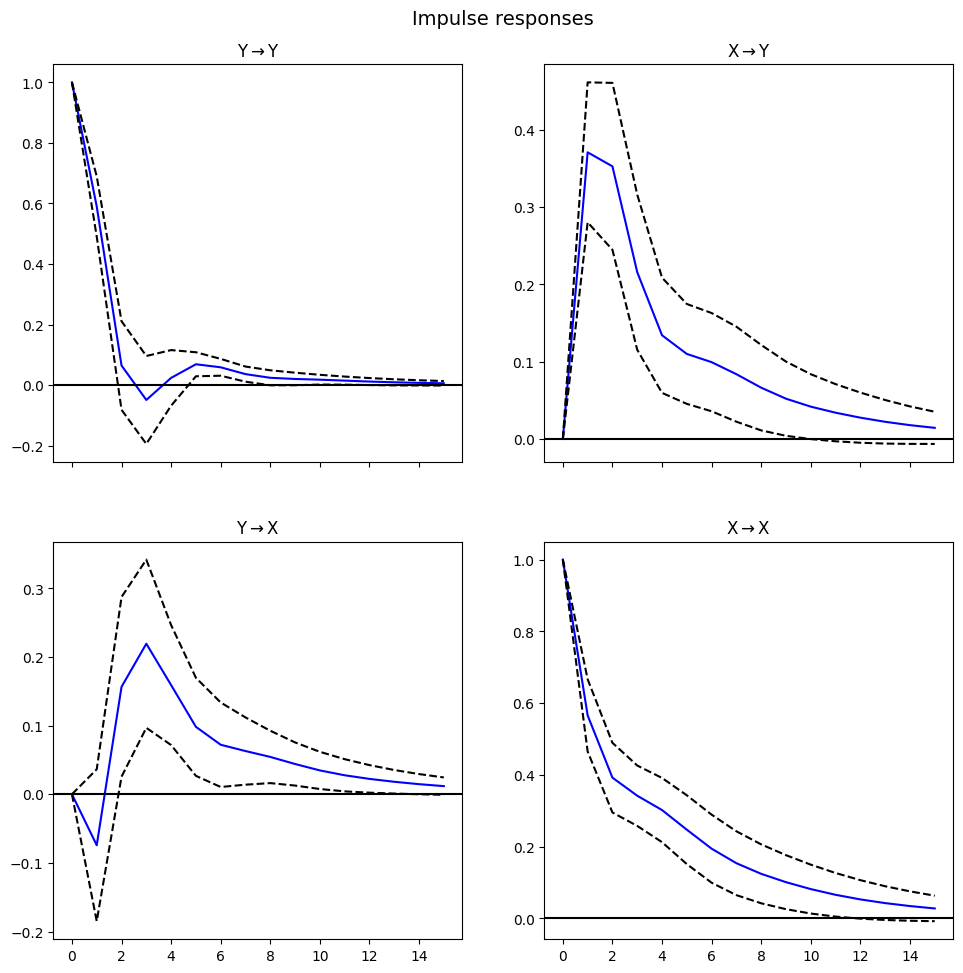

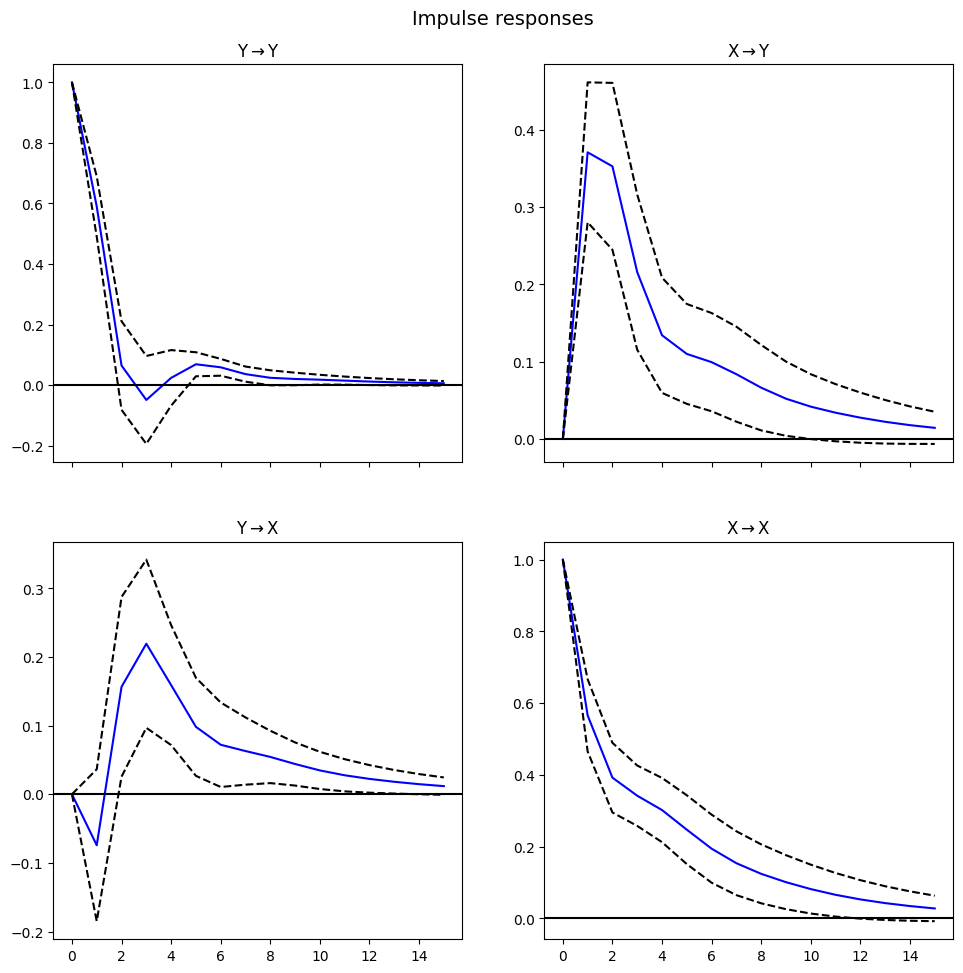

In [37]:
irf.plot(orth = False)

To the unit shocks to the orthogonalized residuals:

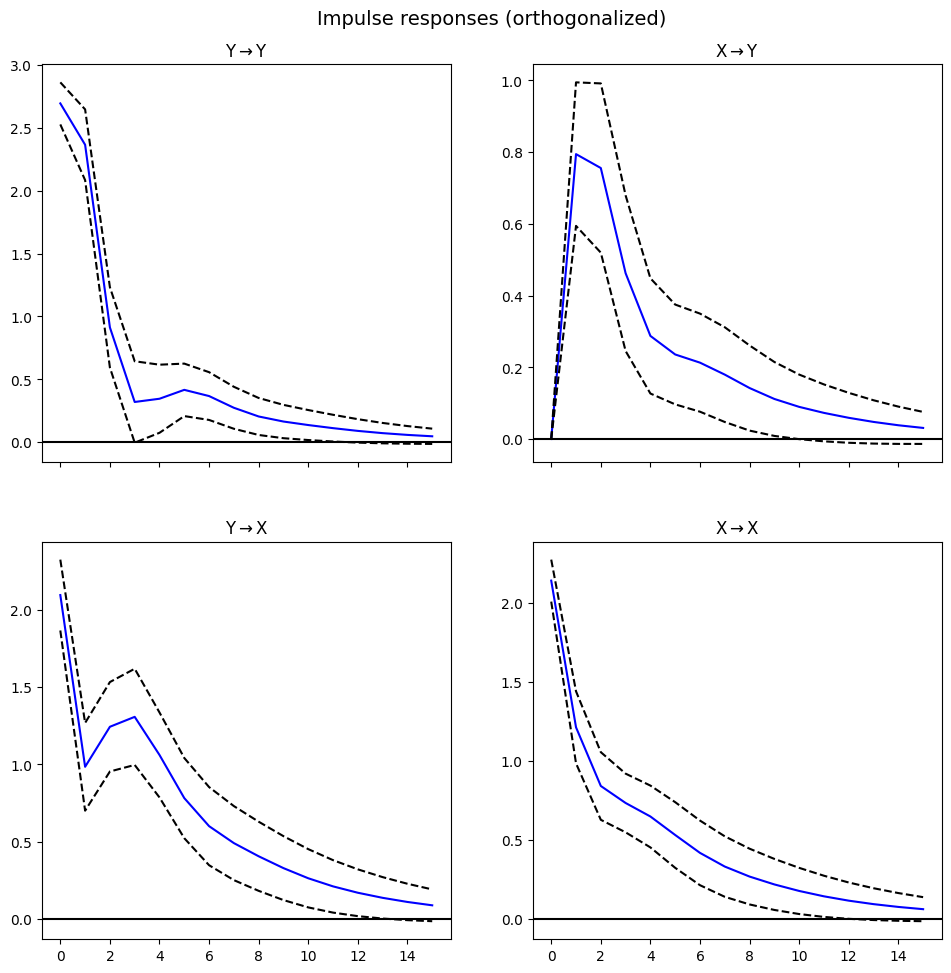

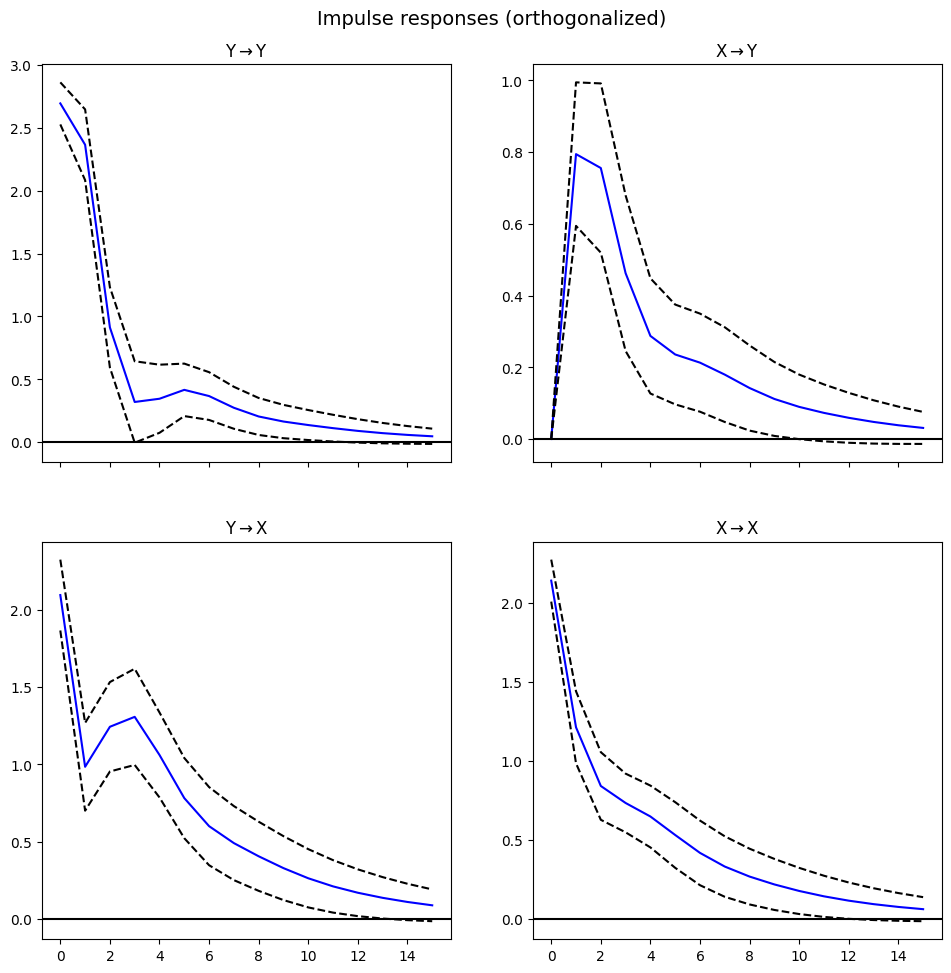

In [38]:
irf.plot(orth = True)

Note that the main dirrerence is the magnitude of the impulses and impulse of Y and the response of Y and X.

The cumulative effects $\Psi_{n}=\sum_{i=0}^{n}\Phi_{i}$ (i.e. where each period is the sum of the current and previous period response values) can be plotted with the long run effects:

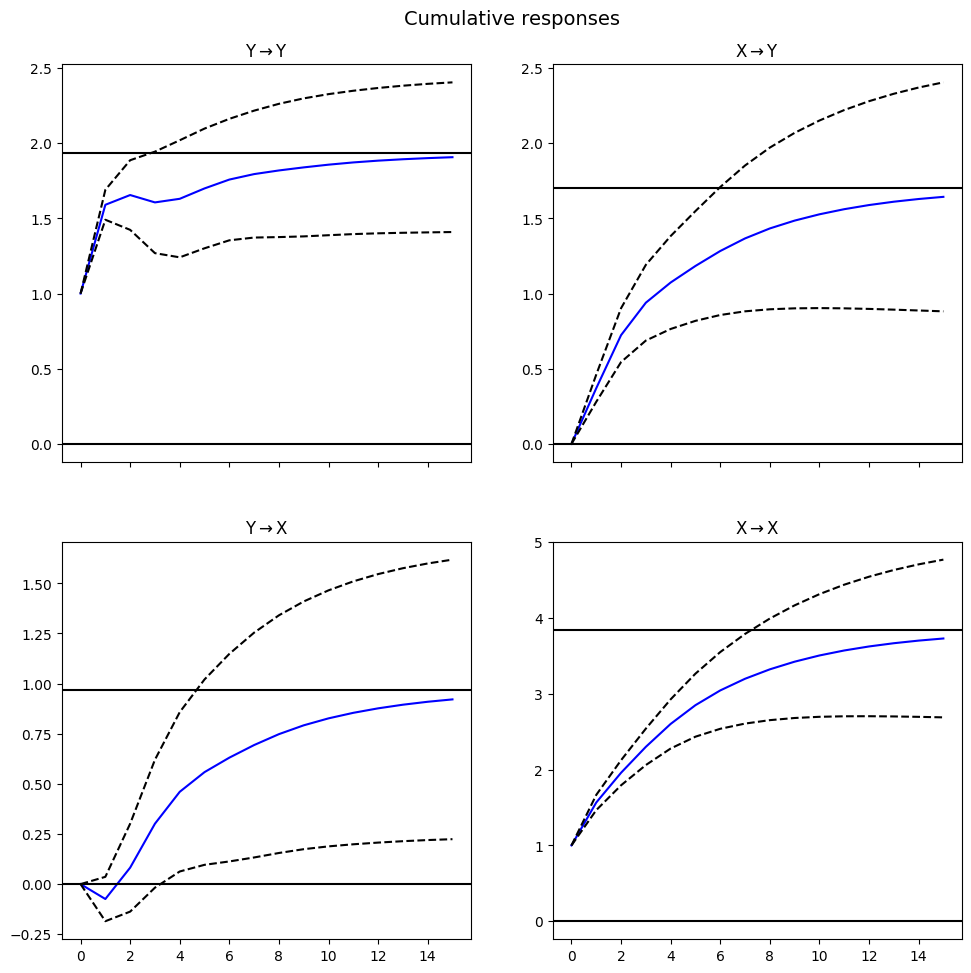

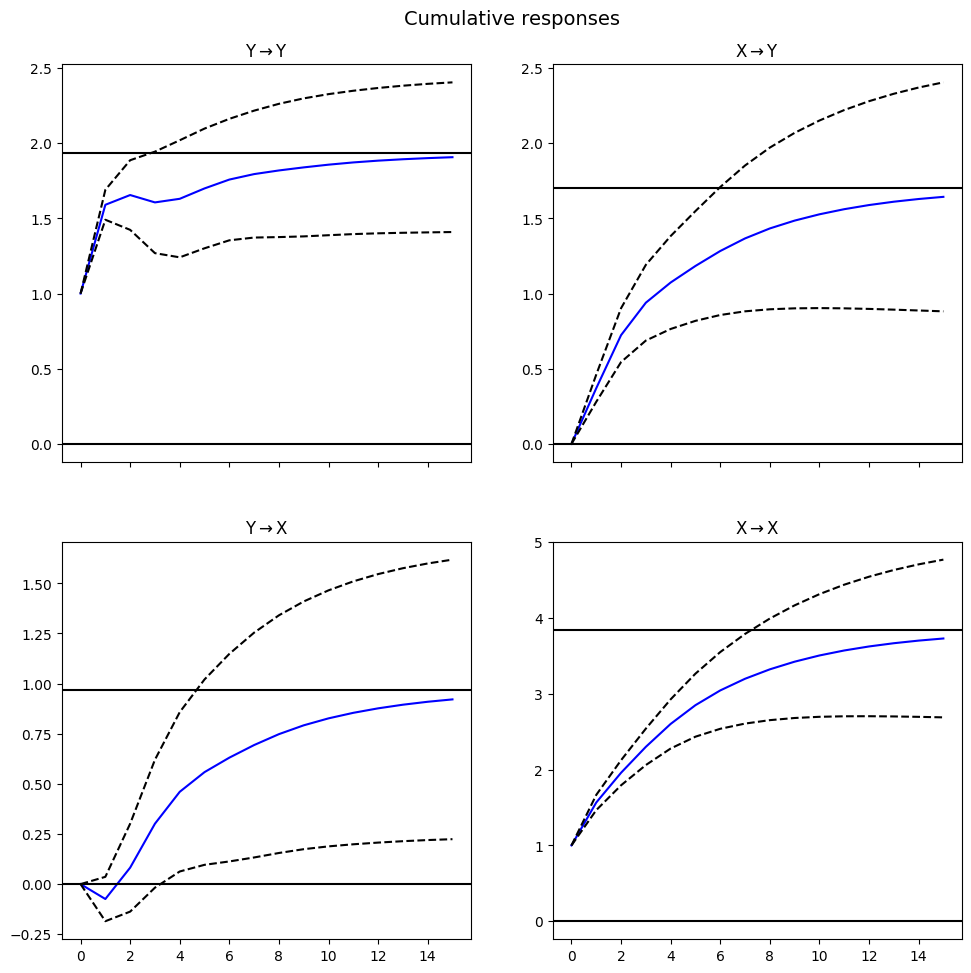

In [39]:
irf.plot_cum_effects(orth=False)

### VAR model Forecasts

finally, we vant calculate the forecasts:

(425.0, 534.45)

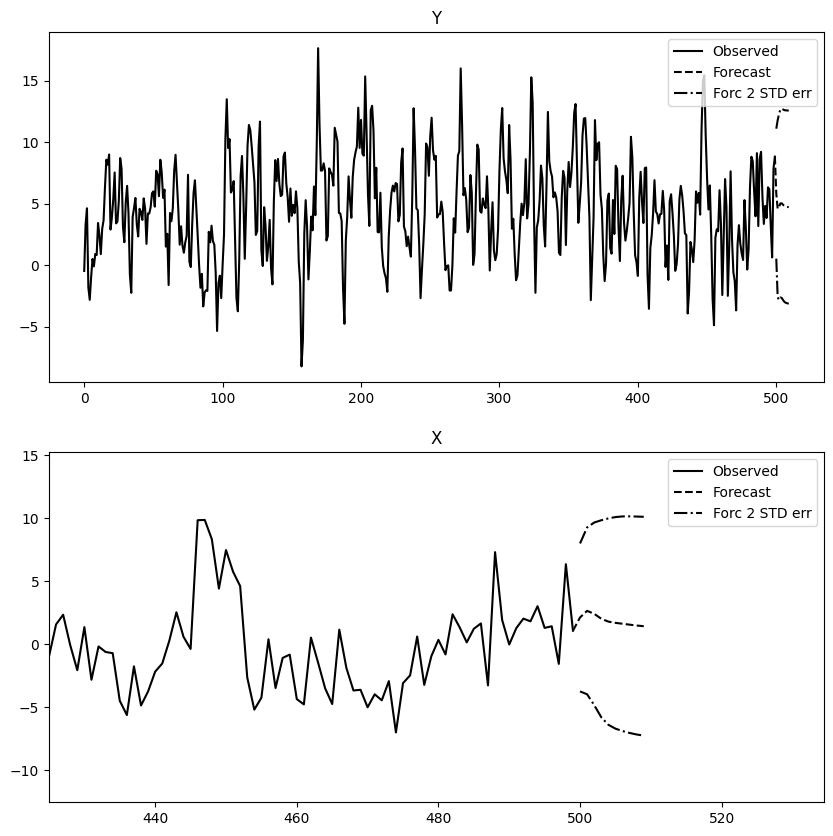

In [40]:
results.plot_forecast(10)
plt.xlim(xmin=425) # we can subset the last variable forecast plot

We can also extract the forecast and confidence intervals manually:

In [41]:
forecasts = results.forecast_interval(Y.values, 10)
forecasts

(array([[5.80189502, 2.14011442],
        [4.57488068, 2.66405364],
        [4.73485891, 2.42735991],
        [5.01546022, 2.03640298],
        [5.01313619, 1.80948079],
        [4.88557064, 1.71027289],
        [4.79135097, 1.64043578],
        [4.75002143, 1.56711957],
        [4.72785047, 1.49891059],
        [4.70561661, 1.44463752]]),
 array([[ 0.51846318, -3.73296331],
        [-2.62616573, -3.95950019],
        [-2.83167012, -4.82014334],
        [-2.63088704, -5.78386569],
        [-2.68378843, -6.38156632],
        [-2.86824841, -6.687699  ],
        [-3.00690802, -6.87909669],
        [-3.07456707, -7.03115151],
        [-3.11193269, -7.15204616],
        [-3.14381523, -7.2409047 ]]),
 array([[11.08532685,  8.01319216],
        [11.77592709,  9.28760748],
        [12.30138794,  9.67486317],
        [12.66180748,  9.85667165],
        [12.71006081, 10.00052791],
        [12.6393897 , 10.10824478],
        [12.58960997, 10.15996824],
        [12.57460992, 10.16539065],
        

In [43]:
# mean forecasts:
forc = forecasts[0]
# lower confidence bound:
l_bound = forecasts[1]
# upper confidence bound:
u_bound =  forecasts[2]

In [44]:
# Combine into a single one:
tmp_forc = np.concatenate((forecasts), axis=1)

In [45]:
# Create an empty data frame:
Y_forc = np.empty((len(Y.index), len(Y.columns)*3))
Y_forc[:] = np.nan

In [46]:
Y_forc = pd.DataFrame(np.append(Y_forc, tmp_forc, axis = 0), columns = ["Y_forc", "X_forc", "Y_forc_lower", "X_forc_lower", "Y_forc_upp", "X_forc_upp"])
Y_forc.index = pd.date_range(start = "2014-01-01", periods = len(Y_forc.index), freq = "D").to_period()
Y_forc.index = Y_forc.index.to_timestamp()

In [47]:
Y_forc.tail(11)

,Y_forc,X_forc,Y_forc_lower,X_forc_lower,Y_forc_upp,X_forc_upp
2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-16,5.801895,2.140114,0.518463,-3.732963,11.085327,8.013192
2015-05-17,4.574881,2.664054,-2.626166,-3.959500,11.775927,9.287607
2015-05-18,4.734859,2.427360,-2.831670,-4.820143,12.301388,9.674863
2015-05-19,5.015460,2.036403,-2.630887,-5.783866,12.661807,9.856672
2015-05-20,5.013136,1.809481,-2.683788,-6.381566,12.710061,10.000528
2015-05-21,4.885571,1.710273,-2.868248,-6.687699,12.639390,10.108245
2015-05-22,4.791351,1.640436,-3.006908,-6.879097,12.589610,10.159968
2015-05-23,4.750021,1.567120,-3.074567,-7.031152,12.574610,10.165391
2015-05-24,4.727850,1.498911,-3.111933,-7.152046,12.567634,10.149867


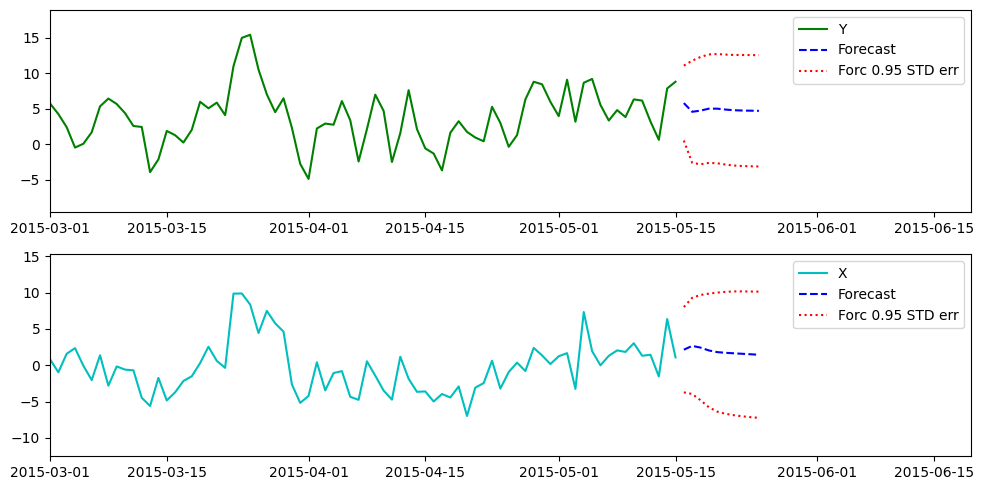

In [48]:

#Subplot layout = 2 rows and 1 column - we only need one index
f, axarr = plt.subplots(2, 1) # if we had layout = 2 rows and 2 columns - we would need to use [i, j] indexes to access different subplots
#Size of the figure output: - also works with   plt.subplots(2, 1, figsize = (10, 5))
f.set_figheight(5)
f.set_figwidth(10)

#Plot the first series:
axarr[0].plot(Y["Y"], "g-", label = "Y")
axarr[0].plot(Y_forc[["Y_forc"]], "b--", label = "Forecast")
axarr[0].plot(Y_forc[["Y_forc_lower"]], "r:", label = "Forc 0.95 STD err")
axarr[0].plot(Y_forc[["Y_forc_upp"]], "r:")
#Change the range to show the historic values from 2015 January:
axarr[0].set_xlim(xmin = pd.to_datetime("2015-03-01"))
#Add a legend:
axarr[0].legend()

#Plot the second series:
axarr[1].plot(Y["X"], "c-", label = "X")
axarr[1].plot(Y_forc[["X_forc"]], "b--", label = "Forecast")
axarr[1].plot(Y_forc[["X_forc_lower"]], "r:", label = "Forc 0.95 STD err")
axarr[1].plot(Y_forc[["X_forc_upp"]], "r:")
#Change the range to show the historic values from 2015 January:
axarr[1].set_xlim(xmin = pd.to_datetime("2015-03-01"))
#Add a legend:
axarr[1].legend()

plt.tight_layout()


### VAR model residual diagnostics

Finally, we can examine the residuals of our model:

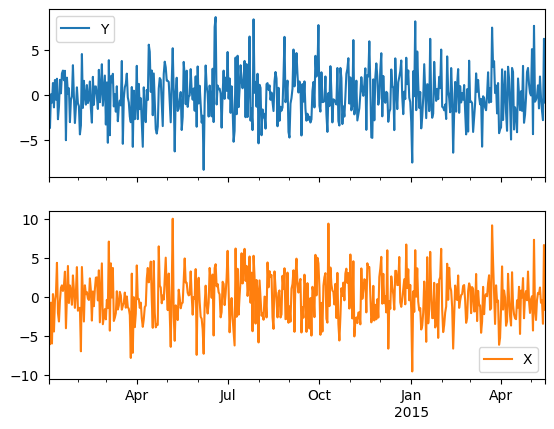

In [49]:
results.resid.plot(subplots=True)
plt.show()

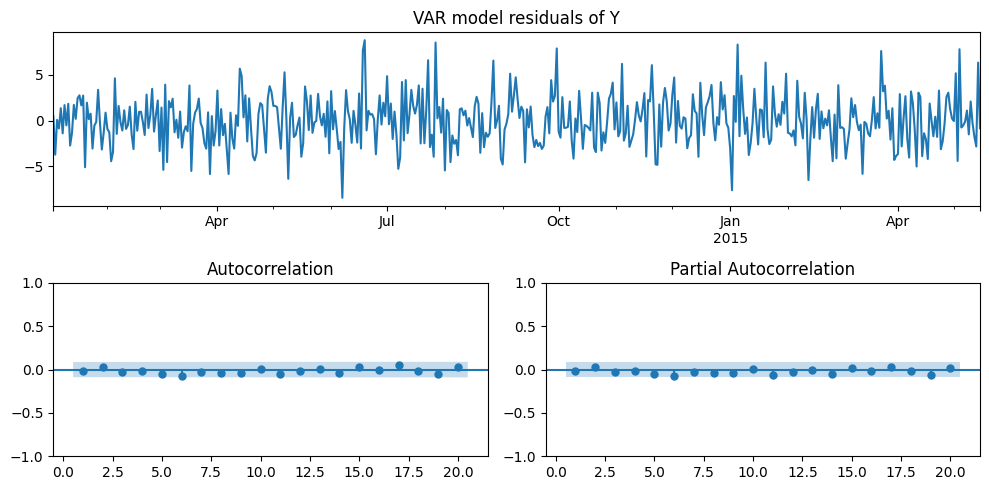

In [50]:
fig = plt.figure(figsize = (10, 5))
results.resid["Y"].plot(ax = fig.add_subplot(211))
plt.title("VAR model residuals of Y")
sm.graphics.tsa.plot_acf(results.resid["Y"], lags = 20, zero = False, ax = fig.add_subplot(223))
sm.graphics.tsa.plot_pacf(results.resid["Y"], lags = 20, zero = False, ax = fig.add_subplot(224))
plt.tight_layout()
plt.show()

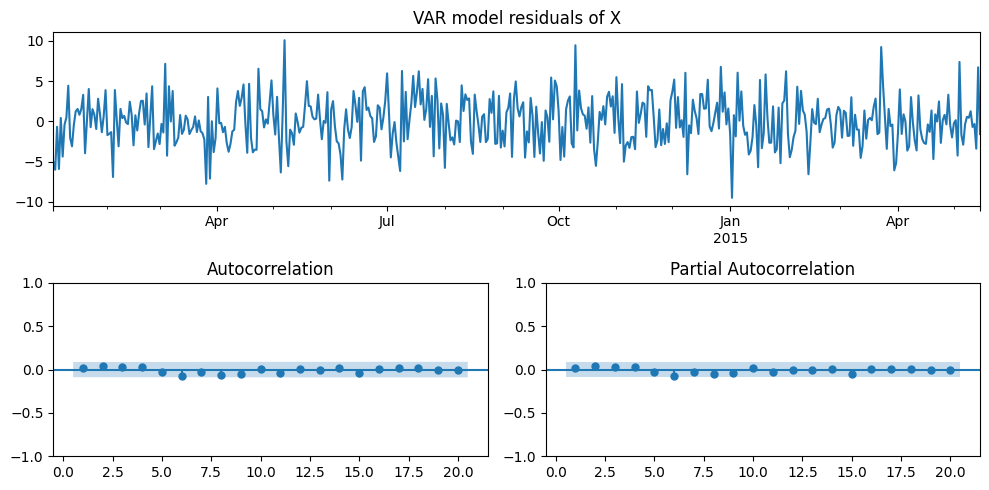

In [51]:
fig = plt.figure(figsize = (10, 5))
results.resid["X"].plot(ax = fig.add_subplot(211))
plt.title("VAR model residuals of X")
sm.graphics.tsa.plot_acf(results.resid["X"], lags = 20, zero = False, ax = fig.add_subplot(223))
sm.graphics.tsa.plot_pacf(results.resid["X"], lags = 20, zero = False, ax = fig.add_subplot(224))
plt.tight_layout()
plt.show()

From the ACF
and PACF plots we can say that the residuals are white noise. We can conslude that the specified model is acceptible for our data sample.

### VECM

In general Error Correction Models (ECM's) are useful for estimating both the short-term and the long-term effects of either a univariate of multivariate time series. The error-correction term relates to the fact that the last-period's deviation from the long-run equilibrium, the error, influences its short-run dynamics. So ECMS's directly estimate the speed of which a dependent variable returns to equilibrium after a change in other variables.

In the multivariate case, a VECM is just a representation fo a cointegrated VAR. This means that we can specify a cointegrated VAR in the form of a VECM and vice versa. The VECM representation also impses restrictions of the coefficients, which are based on the number of cointegrating relationships. These restrictions lead to more efficient coefficient estimates of the VECM, compared to the VAR representation (which does not impose those restrictions).


#### VECM Example(1)

We will examine the following VAR(1) model:
$$
\begin{equation}
    \begin{pmatrix}
        Y_{1,t} \\
        Y_{2,t}
    \end{pmatrix}
    =
    \begin{pmatrix}
        1 \\
        2
    \end{pmatrix}
    +
    \begin{pmatrix}
        0.5 & -1 \\
        -0.25 &0.5
    \end{pmatrix}
    \begin{pmatrix}
        Y_{1,t-1}\\
        Y_{2,t-1}
    \end{pmatrix}
    +
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    ,
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
    \sim
    \mathbb{N}
    \begin{pmatrix}
        \begin{bmatrix}
            0\\
            0
        \end{bmatrix}
        ,
        \begin{bmatrix}
            1 &0\\
            0 &1
        \end{bmatrix}
    \end{pmatrix}
\end{equation}
$$


In [52]:
nsmaple = 500

alpha = np.array([1,2])
theta_1 = np.array([[0.5, -1], [-0.25, 0.5]])

mu = [0,0]
sigma = np.array([[1,0],[0,1]])

We begin by checking the stability (which implies stationarity) of the model:

In [53]:
z = Symbol('z')
D = Matrix([[1, 0], [0, 1]]) - Matrix(theta_1) * z

temp_roots = roots(D.det(), z)
temp_roots = [*temp_roots]

for j in temp_roots:
    print("z = ", N(j, 4), "=> |z| = ", N(Abs(j), 4))

z =  1.000 => |z| =  1.000


Intuition about the cointegration relations

Next, we need to estimate the number of cointegrating relations in the process. If there are none - we differentiate the data and estiamte a VAR model on the (stationary) differences. Otherwise, we need to include an error correction term and work with a VECM.

We subtract $(Y_{1,t-1},Y_{2,t-1})^{T}$ from both sides of the VAR model to get:
$$
\begin{equation}
    \begin{pmatrix}
        \Delta Y_{1,t} \\
        \Delta Y_{2,t}
    \end{pmatrix}
    =
    \begin{pmatrix}
        1 \\
        2
    \end{pmatrix}
    +
    \begin{pmatrix}
        0.5 & -1 \\
        -0.25 &0.5
    \end{pmatrix}
    \begin{pmatrix}
        Y_{1,t-1}\\
        Y_{2,t-1}
    \end{pmatrix}
    +
    \begin{pmatrix}
        \epsilon_{1,t} \\
        \epsilon_{2,t}
    \end{pmatrix}
\end{equation}
$$
where
$$
\begin{equation}
    \Pi =\ \Theta_{1}\ -\ 1\ =\
    \begin{pmatrix}
        0.5 &-1 \\
        -0.25 &0.5
    \end{pmatrix}
    -
    \begin{pmatrix}
        1 &0 \\
        0 &1
    \end{pmatrix}
    =
    \begin{pmatrix}
        -0.5 &-1 \\
        -0.25 &-0.5
    \end{pmatrix}
\end{equation}

In [54]:
PI = Matrix(theta_1) - Matrix([[1,0],[0,1]])
PI

Matrix([
[ -0.5, -1.0],
[-0.25, -0.5]])

The rank of $\Pi$ matrix indicates the number of cointegrating relations:

In [55]:
PI.rank()

1